In [25]:
from datetime import datetime, timedelta
from sqlmodel import Field, Relationship, SQLModel, Session, create_engine, select, col

CYCLE_TIME = 3      # times in hours
db_name = "beboundless_data.db"
sqlite_url = f"sqlite:///{db_name}"
engine = create_engine(sqlite_url)

In [26]:
from beboundless_data_db import Requestors, Orders

one_hour_ago = int((datetime.now() - timedelta(hours=CYCLE_TIME)).timestamp())
with Session(engine) as session:
    statement = select(Requestors).where(Requestors.last_activity >= one_hour_ago)
    results: list[Requestors] = session.exec(statement).all()

address = [r.address for r in results if r.address]
print(address)

data_dict = {}
with Session(engine) as session:
    for addr in address:
        statement = select(Orders).where(
            Orders.created >= one_hour_ago,
            Orders.requestor_address == addr,
            Orders.lock_gas_price != None
        )
        orders = session.exec(statement).all()
        data_dict[addr] = [(order.order_id, order.created, order.lock_txn, order.lock_gas_price) for order in orders if order.lock_gas_price]
print(data_dict)

['0x2546c553d857d20658ece248f7c7d0861a240681', '0xc2db89b2bd434ceac6c74fbc0b2ad3a280e66db0', '0x89f12aba0bcda3e708b1129eb2557b96f57b0de6', '0x734df7809c4ef94da037449c287166d114503198', '0xf353bda16a83399c11e09615ee7ac326a5a08ccf']
{'0x2546c553d857d20658ece248f7c7d0861a240681': [('0x2546c553d857d20658ece248f7c7d0861a240681ed344618', 1756988268, '0xfbad6aa6884e86a6f74d268f7b37a1e2ec2dd91e72d864327d80b6948cf6c849', 0.097156406), ('0x2546c553d857d20658ece248f7c7d0861a2406811202b55c', 1756988257, '0x7396f876510a84c229d040524717c0875e41974b75b4f1debd7a18201a3c32ae', 0.154646468), ('0x2546c553d857d20658ece248f7c7d0861a240681dcba9734', 1756988246, '0x026e68aa10e9f051b5f94420de8fd3efa7e863def446fcfff6f65f59b45e034c', 0.155759272), ('0x2546c553d857d20658ece248f7c7d0861a240681bd539ef6', 1756988234, '0x728a7bdef3fadb41a7ba082fa16e05b2b474877873c7c10ac841d3842348d89f', 0.155780921), ('0x2546c553d857d20658ece248f7c7d0861a240681ae6fdf47', 1756988223, '0x57ebc2fe9c576767b4304020d02c124434639130ffe8753

In [27]:
# blacklist = [
#     "0x734df7809c4ef94da037449c287166d114503198",
#     # "0x89f12aba0bcda3e708b1129eb2557b96f57b0de6"
# ]
# data_dict = {addr: orders for addr, orders in data_dict.items() if addr not in blacklist}

whitelist = [
    "0x2546c553d857d20658ece248f7c7d0861a240681",
    "0xc2db89b2bd434ceac6c74fbc0b2ad3a280e66db0",
]
data_dict = {addr: orders for addr, orders in data_dict.items() if addr in whitelist}

print(data_dict)
if not data_dict:
    raise SystemExit("No data found")

{'0x2546c553d857d20658ece248f7c7d0861a240681': [('0x2546c553d857d20658ece248f7c7d0861a240681ed344618', 1756988268, '0xfbad6aa6884e86a6f74d268f7b37a1e2ec2dd91e72d864327d80b6948cf6c849', 0.097156406), ('0x2546c553d857d20658ece248f7c7d0861a2406811202b55c', 1756988257, '0x7396f876510a84c229d040524717c0875e41974b75b4f1debd7a18201a3c32ae', 0.154646468), ('0x2546c553d857d20658ece248f7c7d0861a240681dcba9734', 1756988246, '0x026e68aa10e9f051b5f94420de8fd3efa7e863def446fcfff6f65f59b45e034c', 0.155759272), ('0x2546c553d857d20658ece248f7c7d0861a240681bd539ef6', 1756988234, '0x728a7bdef3fadb41a7ba082fa16e05b2b474877873c7c10ac841d3842348d89f', 0.155780921), ('0x2546c553d857d20658ece248f7c7d0861a240681ae6fdf47', 1756988223, '0x57ebc2fe9c576767b4304020d02c124434639130ffe87538d48242c111fbd4ba', 0.101446393), ('0x2546c553d857d20658ece248f7c7d0861a2406813a64324d', 1756988212, '0x1900f27a8ea03e7afa4ba4a80d265071e5f7b448e3eb99a99f70c48c6e9485ca', 0.151283412), ('0x2546c553d857d20658ece248f7c7d0861a240681ce

Group stats:
                                      address  count      mean       std  \
0  0x2546c553d857d20658ece248f7c7d0861a240681    546  0.207390  0.370456   
1  0xc2db89b2bd434ceac6c74fbc0b2ad3a280e66db0    473  0.278131  0.514312   

        min       max    median       q25       q75 best_range  
0  0.000877  1.501503  0.086728  0.024832  0.150000  0.02~0.15  
1  0.001795  1.798972  0.076519  0.068616  0.103905  0.07~0.10  
Good suppliers:
                                      address  count      mean       std  \
0  0x2546c553d857d20658ece248f7c7d0861a240681    546  0.207390  0.370456   
1  0xc2db89b2bd434ceac6c74fbc0b2ad3a280e66db0    473  0.278131  0.514312   

        min       max    median       q25       q75 best_range  
0  0.000877  1.501503  0.086728  0.024832  0.150000  0.02~0.15  
1  0.001795  1.798972  0.076519  0.068616  0.103905  0.07~0.10  
Gas price boxplot:


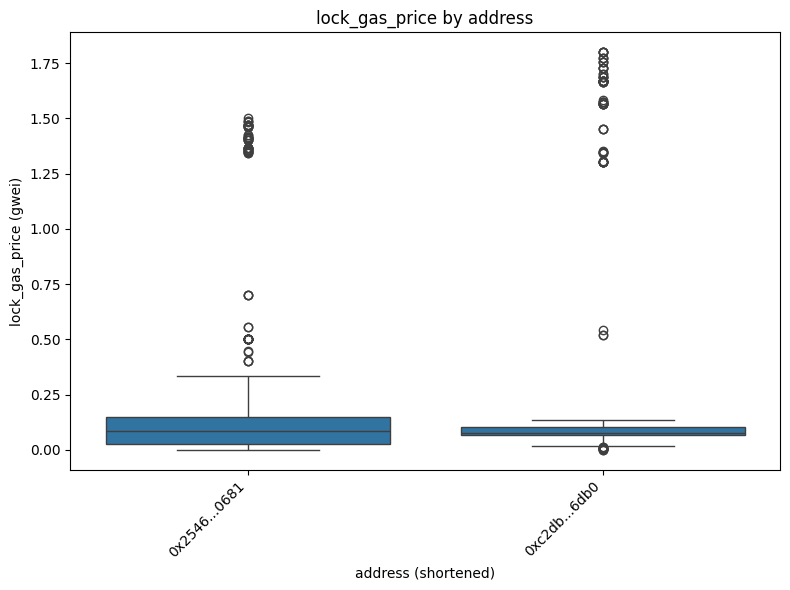

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame([
    {"address": addr, "order_id": oid, "created": created, "lock_txn": txn, "lock_gas_price": float(gas)}
    for addr, lst in data_dict.items()
    for oid, created, txn, gas in lst
])

# set timezone +8
df["created"] = pd.to_datetime(df["created"] + 8 * 3600, unit="s")

from dc_view import plot_gas_price_boxplot, compute_gas_group_stats, filter_good_suppliers

print("Group stats:")
group_stats = compute_gas_group_stats(df)
print(group_stats)

print("Good suppliers:")
good = filter_good_suppliers(group_stats, min_count=10, max_std=5)
print(good)

print("Gas price boxplot:")
plot_gas_price_boxplot(df)

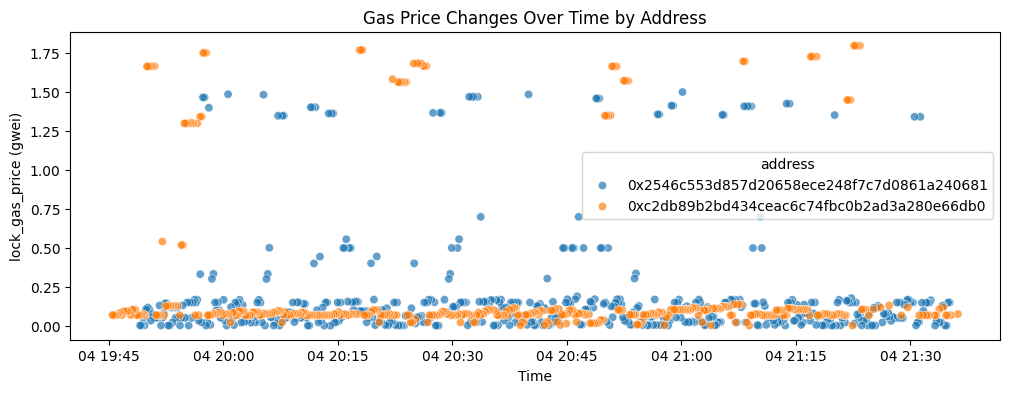

In [29]:
df["created_dt"] = pd.to_datetime(df["created"], unit="s")
plt.figure(figsize=(12, 4))
sns.scatterplot(data=df, x="created_dt", y="lock_gas_price", hue="address", alpha=0.7)
plt.title("Gas Price Changes Over Time by Address")
plt.xlabel("Time")
plt.ylabel("lock_gas_price (gwei)")
plt.show()

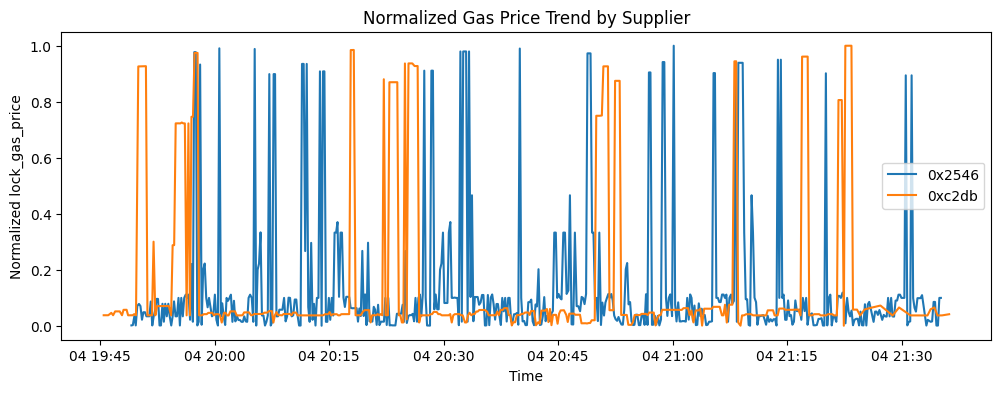

In [30]:
plt.figure(figsize=(12, 4))
for addr, group in df.groupby("address"):
    group = group.sort_values("created_dt")
    norm = (group["lock_gas_price"] - group["lock_gas_price"].min()) / (group["lock_gas_price"].max() - group["lock_gas_price"].min())
    plt.plot(group["created_dt"], norm, label=addr[:6])
plt.legend()
plt.title("Normalized Gas Price Trend by Supplier")
plt.xlabel("Time")
plt.ylabel("Normalized lock_gas_price")
plt.show()

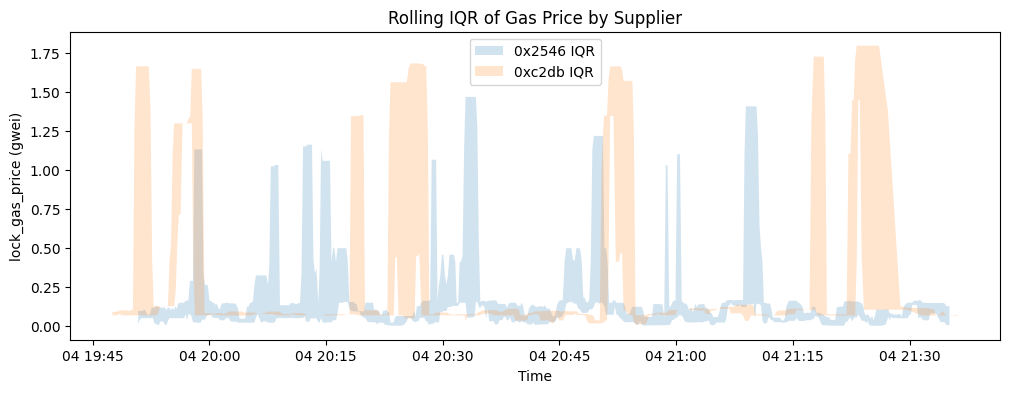

In [31]:
window = 10
plt.figure(figsize=(12, 4))
for addr, group in df.groupby("address"):
    group = group.sort_values("created_dt")
    rolling_q25 = group["lock_gas_price"].rolling(window).quantile(0.25)
    rolling_q75 = group["lock_gas_price"].rolling(window).quantile(0.75)
    plt.fill_between(group["created_dt"], rolling_q25, rolling_q75, alpha=0.2, label=f"{addr[:6]} IQR")
plt.legend()
plt.title("Rolling IQR of Gas Price by Supplier")
plt.xlabel("Time")
plt.ylabel("lock_gas_price (gwei)")
plt.show()


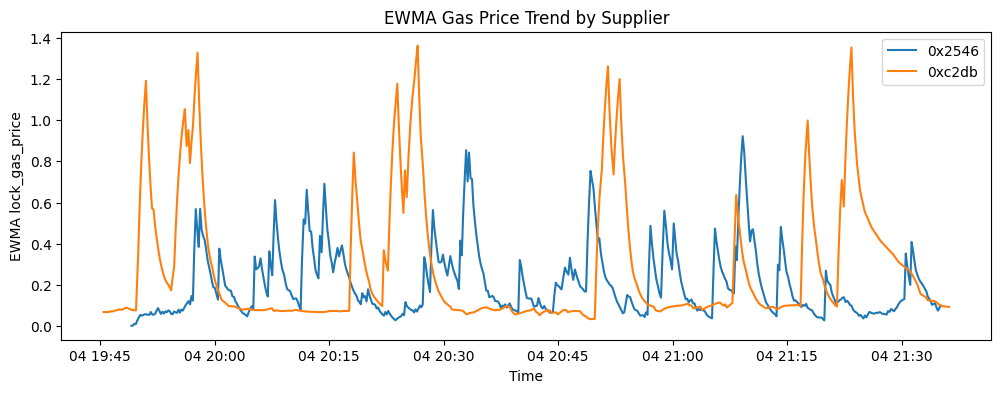

In [32]:
plt.figure(figsize=(12, 4))
for addr, group in df.groupby("address"):
    group = group.sort_values("created_dt")
    ewma = group["lock_gas_price"].ewm(span=10, adjust=False).mean()
    plt.plot(group["created_dt"], ewma, label=addr[:6])
plt.legend()
plt.title("EWMA Gas Price Trend by Supplier")
plt.xlabel("Time")
plt.ylabel("EWMA lock_gas_price")
plt.show()
